# Long Short-Term Memory Recurrent Neural Networks in PyTorch
Recurrant neural networks of all flavors or designed to mimic the human idea of "memory", and are therefore uniquely poised to handle problems that involve sequences of related data. Traditionally, we might think of a sequence as something that spans time (time series data), but we can also apply RNNs to natural language processing problems. 

## The Idea Behind LSTMs
Recurrent neural networks in general maintain state information about the data last passed through the network. This is true of both vanilla RNNs and LSTMs. This "hidden state", as it is called is passed back into the network along with each new element of a sequence. Therefore, each output of the network is a function not only of the input variables, but of the hidden state that serves as "memory" of what the network has seen in the past.

To understand LSTMS, we must understand the gap that they fill in the abilities of traditional RNNs. Where vanilla RNN's fail in that they suffer from rapid gradient vanishing or explosion of gradients. Roughly speaking, this is caused by the fact that the formulation of the hidden state results in an exponential term $W^T$ when applying the chain rule. Therefore, when certain conditions of the base matrix $W$ are met, the term may either explode or vanish very quickly.

LSTMs do not suffer (as badly) from this problem, and are therefore able to maintain longer "memory", making them ideal for learning temporal data.

## Understanding Data Flow: LSTM Layer
Perhaps the single most difficult concept to grasp when learning LSTMs after other types of networks is how the data flows through the layers of the model. 

It's not magic, but it may seem so:

1. An LSTM layer is comprised of a set of $N$ hidden nodes. This value $N$ is assigned by the user when the model object is instantiated. 

2. When a single sequence $S$ of length $M$ is passed into the network, each individual element $s_i$ of the sequence $S$ is passed through each and every hidden node.

3. Each hidden node gives a single output for each input it sees. This results in an overall output from the hidden layer of shape $(M, N)$

4. If mini-batches of $B$ sequences are fed to the network, there is an additional dimension added, resulting in an output of shape $(B, M, N)$

![title](imgs/Flowchart.png)

## Understanding Data Flow: Fully Connected Layer
After an LSTM layer (or set of LSTM layers), we typically add a fully connected layer to the network for final output via the `nn.Linear()` class.

1. The input size for the final `nn.Linear()` layer will always be equal to the number of hidden nodes in the LSTM layer that precedes it.

2. The output of this final fully connected layer will depend on the form of the targets and/or loss function you are using.

Point 2 above bears expanding on with a couple of examples with different kinds of data and different desired outcomes. That's what we'll do next.

## Understanding Data Flow: Examples
We will go over 2 examples:

1. Regression
2. Classification

### Example 1a: Regression Network Architecture
Consider some time-series data, perhaps stock prices. Given a the past 7 days worth of stock prices for a particular product, we wish to predict the the 8th day's price. In this case, we wish our output to be a single value. We will evaluate the accuracy of this single value using MSE, so for both prediction and for performance evaluations, we need a single valued output. Therefore, we would define our network architecture something like:

In [ ]:
input_size = 1    # The number of variables in your sequence data. 
n_hidden   = 100  # The number of hidden nodes in the LSTM layer.
n_layers   = 2    # The total number of LSTM models you wish to stack.
out_size   = 1    # The size of the output you desire from your RNN

lstm   = nn.LSTM(input_size, n_hidden, n_layers)
linear = nn.Linear(n_hidden, 1)

### Example 1b: Shaping Data Between Layers

I'll let you in on a little secret that a friend of mine once told me:

> _These days I have an understanding of it_ [LSTM data flow] _that works if I kind of look away while I'm doing it._
>
>-- Alec

While what he says is true in a sense, I think we can pin down some specifics of how this machine works. 

1. __The input__ to the LSTM layer must be of shape `(batch_size, sequence_length, number_features)`, where `batch_size` refers to the number of sequences per batch and `number_features` is the number of variables in your time series. 

2. __The output__ of your LSTM layer will be shaped like `(batch_size, sequence_length, hidden_size)`. Take another look at the flow chart I created above. 

3. __The input__ of our fully connected `nn.Linear()` layer requires an input size corresponding to the number of hidden nodes in the preceding LSTM layer. Therefore we must reshape our data into the form `(batches, n_hidden)`. 

__Important note:__ `batches` is not the same as `batch_size` in the sense that they are not the same number. However, the idea is the same in that we are dividing up the output of the LSTM layer into `batches` number of pieces, where each piece is of size `n_hidden`, the number of hidden LSTM nodes. 

Here is some code that simulates passing input data `x` through the entire network, following the protocol above:

In [1]:
input_size = 1    # The number of variables in your sequence data. 
n_hidden   = 100  # The number of hidden nodes in the LSTM layer.
n_layers   = 2    # The total number of LSTM models you wish to stack.
out_size   = 1    # The size of the output you desire from your RNN

lstm   = nn.LSTM(input_size, n_hidden, n_layers, batch_first=True)
linear = nn.Linear(n_hidden, 1)

x = get_batches(data)          # -> input x:    (batch_size, seq_length, num_features)
x, hs = lstm(x, hs)            # -> LSTM out:   (batch_size, seq_length, hidden_size)
x = x.reshape(-1, hidden_size) # -> Linear in:  (batch_size * seq_length, hidden_size)
x = linear(x)                  # -> Linear out: (batch_size * seq_length, out_size)

Recall that `out_size = 1` because we only wish to know a single value, and that single value will be evaluated using MSE as the metric.

### Example 2a: Classification Network Architecture

In this example, we want to generate some text. A model is trained on a large body of text, perhaps a book, and then fed a single or sequence of characters. The model will look at each character and predict which character should come next. This time our problem is one of classification rather than regression, and we must alter our architecture accordingly. I created this diagram to sketch the general idea:

![title](imgs/Drawing.jpg)

Perhaps our model has trained on a text of millions of words made up of 50 unique characters. What this means that when our network gets a single character, we wish to know which of 50 characters comes next. Therefore our network output for a single character will be 50 probabilities corresponding to each of 50 possible next characters. 

Additionally, we will one-hot encode each character in a string of text, meaning the number of variables (`input_size`) is no longer one as it was before, but rather is the size of the one-hot encoded character vectors.

In [ ]:
input_size  = 50  # representing the one-hot encoded vector size
hidden_size = 100 # number of hidden nodes in the LSTM layer
n_layers    = 2   # number of LSTM layers
output_size = 50  # output of 50 scores for the next character

lstm   = nn.LSTM(input_size, hidden_size, n_layers, batch_first=True)
linear = nn.Linear(hidden_size, output_size)

### Example 2b: Shaping Data Between Layers
As far as shaping the data between layers, there isn't much difference. The logic is identical:

In [ ]:
input_size  = 50  # representing the one-hot encoded vector size
hidden_size = 100 # number of hidden nodes in the LSTM layer
n_layers    = 2   # number of LSTM layers
output_size = 50  # output of 50 scores for the next character

lstm   = nn.LSTM(input_size, hidden_size, n_layers, batch_first=True)
linear = nn.Linear(hidden_size, output_size)

x = get_batches(data)          # -> input x:    (batch_size, seq_length, num_features)
x, hs = lstm(x, hs)            # -> LSTM out:   (batch_size, seq_length, hidden_size)
x = x.reshape(-1, hidden_size) # -> Linear in:  (batch_size * seq_length, hidden_size)
x = linear(x)                  # -> Linear out: (batch_size * seq_length, out_size)

However, this scenario presents a unique challenge. Because we are dealing with categorical predictions, we will likely want to use cross entropy loss to train our model. In this case it is __so important__ to know your loss function's requirements. For example, take a look at PyTorch's `nn.CrossEntropyLoss()` input requirements (emphasis mine, because let's be honest some documentation needs help):


> ___The input___ is expected to contain raw, unnormalized scores for each class.
> ___The input___ has to be a Tensor of size either (minibatch, C)...
>
> This criterion __[Cross Entropy Loss]__ expects a class index in the range [0, C-1] as ___the target___ for each value of a __1D tensor__ of size minibatch.

Okay, no offense PyTorch, but that's shite. I'm not sure it's even English. Let me translate:

1. The prediction (called input above, even though there are two inputs) should be of shape (minibatch, C) where C is the number of possible classes. In our example `C = 50`. 

2. The target, which is the second input should be of size (minibatch, 1). In other words the target __should not__ be one-hot encoded. 

What this means for you is that you will have to shape your training data in two different ways. Inputs `x` will be one-hot encoded but your targets `y` must be label encoded. Further, the one-hot columns of `x` should be indexed in line with the label encoding of `y`.

In [ ]:
# Assume 26 unique characters
alphabet = ['a', 'b', ... , 'z']

x = np.array(list('abc')) # inputs
y = np.array(list('xyz')) # targets

onehot_encoder = OneHotEncoder(sparse=False).fit(alphabet)
label_encoder  = {ch: i for i, ch in enumerate(alphabet)}
criterion = nn.CrossEntropyLoss()

x = onehot_encoder.transform(x)
y = [label_encoder[ch] for ch in y]

input_size  = 50  # representing the one-hot encoded vector size
hidden_size = 100 # number of hidden nodes in the LSTM layer
n_layers    = 2   # number of LSTM layers
output_size = 50  # output of 50 scores for the next character

lstm   = nn.LSTM(input_size, hidden_size, n_layers, batch_first=True)
linear = nn.Linear(hidden_size, output_size)

x = get_batches(data)          # -> input x:    (batch_size, seq_length, num_features)
x, hs = lstm(x, hs)            # -> LSTM out:   (batch_size, seq_length, hidden_size)
x = x.reshape(-1, hidden_size) # -> Linear in:  (batch_size * seq_length, hidden_size)
x = linear(x)                  # -> Linear out: (batch_size * seq_length, out_size)

loss = criterion(x, y)

## Parting Thoughts:
LSTMs can be complex in their implementation. Most of this complexity can be eliminated by understanding  Each problem you might wish to solve will likely require a seemingly way of doing business. However, I hope that the above gave you some idea of how the logic and flows. Good luck!

In [2]:
import torch
import numpy as np

from torch import nn, optim
import torch.nn.functional as F
from sklearn.preprocessing import OneHotEncoder

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Define a model:
class Network(nn.Module):
    def __init__(self, vocab, n_hidden, n_layers, do=0.5):
        super().__init__()
        
        self.vocab    = vocab
        self.int2char = {i: ch for i, ch in enumerate(vocab)}
        self.char2int = {ch: i for i, ch in self.int2char.items()}
        self.encoder  = OneHotEncoder(sparse=False).fit(vocab.reshape(-1, 1))
        
        self.n_hidden = n_hidden 
        self.n_layers = n_layers
        self.lstm = nn.LSTM(len(vocab), n_hidden, n_layers, batch_first=True, dropout=do)
        self.fc   = nn.Linear(n_hidden, len(vocab))
        
    def forward(self, x, hs=None):
        x, hs = self.lstm(x, hs)          # -> (batch_size, seq_len, n_hidden)
        x = x.reshape(-1, self.n_hidden)  # -> (batch_size * seq_len, n_hidden)
        out = self.fc(x)                  # -> (batch_size * seq_len, vocab_size)
        
        return out, hs 
    
    def predict(self, char, top_k=None, hs=None):
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.to(device)
        self.eval()
        
        with torch.no_grad():
            x = np.array([char])
            x = x.reshape(-1, 1)
            x = self.onehot_encode(x)
            x = x.reshape(1, 1, -1)
            x = torch.tensor(x, dtype=torch.float32)
            x = x.to(device)

            out, hs = self(x, hs)

            ps   = F.softmax(out, dim=1).squeeze()
            
            if top_k is None:
                choices = np.arange(len(self.vocab))
            else:
                ps, choices = ps.topk(top_k)
                choices = choices.cpu().numpy()
            
            ps = ps.cpu().numpy()
            
            char = np.random.choice(choices, p=ps/ps.sum())
            char = self.int2char[char]

        return char, hs
    
    
    def sample(self, length, top_k=None, primer='And Victoria sang '):
        hs = None
        for px in primer:
            out, hs = self.predict(px, hs=hs)
        
        chars = [ch for ch in primer]
        for ix in range(length):
            char, hs = self.predict(chars[-1], top_k=top_k, hs=hs)
            chars.append(char)
        
        return ''.join(chars)
    
    
    def label_encode(self, data):
        return np.array([self.char2int[ch] for ch in data])
    
    
    def label_decode(self, data):
        return np.array([self.int2char[i] for i in data])
    
    
    def onehot_encode(self, data):
        return self.encoder.transform(data)
    
    
    def onehot_decode(self, data):
        return self.encoder.inverse_transform(data)
        
        

In [4]:
# define a batching method:
def get_batches(data, n_seq, seq_len):
    """
    Takes data of shape (n_samples, n_features), returns batches
    of shape (n_seq, seq_len, n_features)
    """
    n_features = data.shape[1]
    n_chars    = n_seq * seq_len
    n_batches  = int(np.floor(len(data) / n_chars))
    n_keep     = n_batches * n_chars
    
    inputs  = data[:n_keep]
    targets = np.append(data[1:], data[0]).reshape(data.shape)
    targets = targets[:n_keep]
    
    inputs = inputs.reshape(n_seq, -1, n_features)
    targets = targets.reshape(n_seq, -1, n_features)
    
    for i in range(0, inputs.shape[1], seq_len):
        x = inputs[:, i: i + seq_len]
        y = targets[:, i: i + seq_len]
        yield x,y
        

In [5]:
def train(model, data, batch_size, seq_len, epochs, lr=0.01, clip=5, valid=None):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = model.to(device)
    
    opt = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    if valid is not None:
        data  = model.onehot_encode(data.reshape(-1, 1))
        valid = model.onehot_encode(valid.reshape(-1, 1))
    else:
        data  = model.onehot_encode(data.reshape(-1, 1))

    train_loss = []
    valid_loss = []
    
    for e in range(epochs):
        model.train()
        hs = None
        t_loss = 0
        v_loss = 0

        for x, y in get_batches(data, batch_size, seq_len):
            opt.zero_grad()
            x = torch.tensor(x).float()
            x = x.to(device)
            
            out, hs = model(x, hs)
            hs = tuple([h.data for h in hs])

            # invert one-hot of targets for use by cross-entropy loss function
            y = y.reshape(-1, len(model.vocab))
            y = model.onehot_decode(y)
            y = model.label_encode(y.squeeze())
            y = torch.from_numpy(y).long().to(device)

            loss = criterion(out, y.squeeze())
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), clip)
            opt.step()
            
            t_loss += loss.item()
            
        if valid is not None:
            model.eval()
            hs = None
            with torch.no_grad():
                for x, y in get_batches(valid, batch_size, seq_len):

                    x = torch.tensor(x).float()
                    x = x.to(device)

                    # invert one-hot of targets for use by cross-entropy loss function
                    y = y.reshape(-1, len(model.vocab))
                    y = model.onehot_decode(y)
                    y = model.label_encode(y.squeeze())
                    y = torch.from_numpy(y).long().to(device)

                    out, hs = model(x, hs)
                    hs = tuple([h.data for h in hs])

                    loss = criterion(out, y.squeeze())
                    v_loss += loss.item()

                valid_loss.append(np.mean(v_loss))
        
        train_loss.append(np.mean(t_loss))
        
        if e % 2 == 0:
            print(f'------- Epoch {e} ---------')
            print(f'Training Loss: {train_loss[-1]}')
            if valid_loss:
                print(f'Valid Loss: {valid_loss[-1]}')
            
    plt.plot(train_loss, label="Training")
    plt.plot(valid_loss, label="Validation")
    plt.title("Loss vs Epochs")
    plt.legend()
    plt.show()

In [6]:
# get data from file:
with open('data/texts/anna.txt') as data:
    text = data.read()

# get unique characters in text 
vocab = np.array(sorted(set(text)))

# split training and validation sets. Convert text to NumPy arrays
split_idx = int(np.floor(0.1 * len(text)))
trainset = np.array(list(text[:-split_idx]))
validset = np.array(list(text[-split_idx:]))
trainset.shape, validset.shape

((1786701,), (198522,))

In [7]:
n_hidden = 390
n_layers = 2

model = Network(vocab, n_hidden, n_layers)
model

Network(
  (lstm): LSTM(83, 390, num_layers=2, batch_first=True, dropout=0.5)
  (fc): Linear(in_features=390, out_features=83, bias=True)
)

------- Epoch 0 ---------
Training Loss: 429.0852167606354
Valid Loss: 43.43970036506653
------- Epoch 2 ---------
Training Loss: 308.144722700119
Valid Loss: 30.774479389190674
------- Epoch 4 ---------
Training Loss: 231.489612698555
Valid Loss: 24.17638611793518
------- Epoch 6 ---------
Training Loss: 205.95846498012543
Valid Loss: 22.401167035102844
------- Epoch 8 ---------
Training Loss: 195.19748604297638
Valid Loss: 21.644485235214233


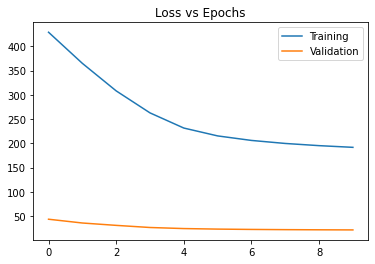

In [8]:
batch_size = 128
seq_len = 100
epochs = 10
lr = 0.01

train(model, trainset, batch_size, seq_len, epochs, lr=lr, valid=validset)

In [11]:
# checkpoint = {
#     'vocab'   : model.vocab,
#     'n_hidden': model.n_hidden,
#     'n_layers': model.n_layers,
#     'state'   : model.state_dict()
# }

# filepath = 'saved/LSTM_390_nodes_25_epochs.net'

# with open(filepath, 'wb') as f:
#     torch.save(checkpoint, f)

In [9]:
with open('saved/LSTM_390_nodes_25_epochs.net', 'rb') as f:
    checkpoint = torch.load(f)

model = Network(vocab, checkpoint['n_hidden'], checkpoint['n_layers'])
model.load_state_dict(checkpoint['state'])

<All keys matched successfully>

In [10]:
text = model.sample(2000, top_k=5)

In [11]:
print(text)

And Victoria sang the place,
was taken from the death of an old man's way. There was on the
part in their conversation again.

"Why, what would
I be seeking at once, and then, and help it? You know how it's a parlies when they
were a chance of mind, we may be to be my seren in the court." Stepan Arkadyevitch answered, as he reached.

"I don't want to see you! Take her all that was not yet to speak," she
said, and trying to spoil her and beginning to
get on the
strain of longing in them, with a smile,
and went on that he did not know herself. The prince came over him with a shirt, and went out onto the subject that humelously and hearing when the patched crowd was satisfeed with her father with her face. She had taken her lips with
these sight.

The princess wished to go to all that he would have taken up the consciousness of his own soul in the difficulty of
water that he had said this to his service, as she went into the sun were always delighted, and
would have been seeing it."

"Oh,